In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

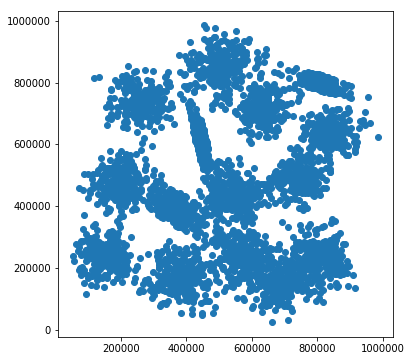

In [4]:
from matplotlib import pyplot as plt
import sklearn.cluster
import sklearn.datasets
import hdbscan
import debacl
import fastcluster
import time
import scipy.cluster
from jklearn.cluster import Omnislash
import numpy as np
import pandas as pd
import requests

data = []
r = requests.get("http://cs.joensuu.fi/sipu/datasets/s2.txt")
for line in r.text.split("\n"):
    if line.strip() == "":
        continue
    x, y = line.strip().split()
    data.append({"x":float(x), "y":float(y)})
df = pd.DataFrame(data)
data = df.as_matrix()

fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(df.x, df.y)

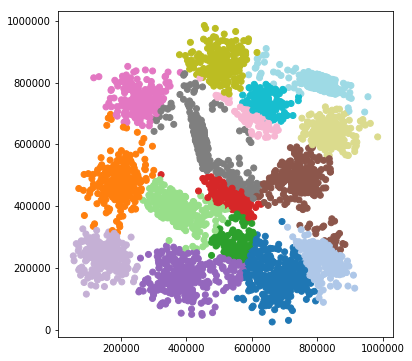

In [18]:
omni = Omnislash(50, evr_max=0.75, sample_space_size=100)
labels = omni.fit_predict(data)
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(df.x, df.y, c=labels, cmap="tab20")

In [ ]:
def benchmark_algorithm_dims(dataset_dimensions, cluster_function, function_args, function_kwds,
                             dataset_size=1000000, dataset_n_clusters=100, max_time=120, sample_size=2):

    # Initialize the result with NaNs so that any unfilled entries
    # will be considered NULL when we convert to a pandas dataframe at the end
    result = np.nan * np.ones((len(dataset_dimensions), sample_size))
    print(repr(cluster_function))
    for index, dim in enumerate(dataset_dimensions):
        print("\t", dim, f"({index+1}/{len(dataset_dimensions)})")
        for s in range(sample_size):
            # Use sklearns make_blobs to generate a random dataset with specified size
            # dimension and number of clusters
            data, labels = sklearn.datasets.make_blobs(n_samples=dataset_size,
                                                       n_features=dim,
                                                       centers=dataset_n_clusters)
            start_time = time.time()
            cluster_function(data, *function_args, **function_kwds)
            del data
            del labels
            time_taken = time.time() - start_time
            result[index, s] = time_taken
            # If we are taking more than max_time then abort -- we don't
            # want to spend excessive time on slow algorithms
        if time_taken > max_time:
            break
            
    # Return the result as a dataframe for easier handling with seaborn afterwards
    return pd.DataFrame(np.vstack([dataset_dimensions.repeat(sample_size),
                                   result.flatten()]).T, columns=['x','y'])

In [ ]:
dataset_dimensions = np.array([int(x) for x in np.logspace(start=2, stop=3, num=1, base=10)])

In [ ]:
omni = Omnislash(5000, evr_max=0.75)
omni_data = benchmark_algorithm_dims(dataset_dimensions, omni.fit, (), {})

k_means = sklearn.cluster.KMeans(100)
k_means_data_dim = benchmark_algorithm_dims(dataset_dimensions, k_means.fit, (), {})

dbscan = sklearn.cluster.DBSCAN(eps=1.25)
dbscan_data_dim = benchmark_algorithm_dims(dataset_dimensions, dbscan.fit, (), {})

fastclust_data = benchmark_algorithm_dims(dataset_dimensions,
                                       fastcluster.linkage_vector, (), {})

hdbscan_ = hdbscan.HDBSCAN()
hdbscan_data = benchmark_algorithm_dims(dataset_dimensions, 
                                        hdbscan_.fit, (), {})

In [ ]:
import seaborn as sns

sns.regplot(x='x', y='y', data=omni_data, order=2,
             label='Omnislash', x_estimator=np.mean)

sns.regplot(x='x', y='y', data=k_means_data_dim, order=2,
            label='Sklearn K-Means', x_estimator=np.mean)

sns.regplot(x='x', y='y', data=dbscan_data_dim, order=2,
            label='Sklearn DBSCAN', x_estimator=np.mean)

sns.regplot(x='x', y='y', data=scipy_k_means_data, order=2,
             label='Scipy K-Means', x_estimator=np.mean)

sns.regplot(x='x', y='y', data=hdbscan_data, order=2,
            label='HDBSCAN', x_estimator=np.mean)

sns.regplot(x='x', y='y', data=fastclust_data, order=2,
            label='Fastcluster Single Linkage', x_estimator=np.mean)

sns.regplot(x='x', y='y', data=scipy_single_data, order=2,
            label='Scipy Single Linkage', x_estimator=np.mean)

plt.gca().axis([0, 650, 0, 200])
plt.gca().set_xlabel('Number of data points')
plt.gca().set_ylabel('Time taken to cluster (s)')
plt.title('Performance Comparison of Clustering Implementations')
plt.legend()

In [ ]:
k_means_data_dim.loc[k_means_data_dim.index == 19, "y"] = k_means_data_dim.loc[k_means_data_dim.index == 18, "y"].values[0]

In [ ]:
dbscan_data_dim